In [1]:
import os
import pickle
from inspect import signature

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc

import missingno as msno
from IPython.display import display, HTML

import warnings
# warnings.filterwarnings('ignore')

# load custom functions
os.chdir('C:/Users/kyleg/Entity-Matching-in-Online-Retail')
#  os.chdir('H:/kgilde/Entity-Matching-in-Online-Retail')
exec(open("utility_functions.py").read())

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# source: https://stackoverflow.com/a/28073228/4463701

# Entity Matching for Online Marketplaces



In [2]:
# Load Data
# DATA_DIRECTORY = '//files/share/goods/OI Team'
ORIGINAL_DIRECTORY = os.getcwd()
DATA_DIRECTORY = 'D:/Documents/Large-Scale Product Matching/'
os.chdir(DATA_DIRECTORY)

# load some feature data
train_test_feature_pairs = pd.read_csv('train_test_feature_pairs.csv')
train_test_offer_features = pd.read_csv('train_test_offer_features.csv')
train_test_normalized_features = pd.read_csv('train_test_normalized_features.csv')
attribute_comp_features_9 = pd.read_csv('attribute_comparison_features-9.csv')

# load some metrics
feature_avgs = pd.read_csv('Output Metrics - Feature Avgs.csv')
model_avgs = pd.read_csv('Output Metrics - Model Avgs.csv')
var_imp_coef = pd.read_csv('logreg-variable-coefficients-importance.csv').set_index('Feature')

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [79]:
# load some models
os.chdir(DATA_DIRECTORY + '/attribute_comparison_features-9')

acf9_models = pickle.load(open('sklearn_models.pkl', 'rb'))
acf9_predictions = pickle.load(open('sklearn_test_predictions.pkl', 'rb'))


acf9_rf_class_proba = pickle.load(open('sklearn_class_probabilities.pkl', 'rb'))[2]
acf9_rf_pred = acf9_predictions[2]
acf9_sgb_class_proba = pickle.load(open('sklearn_class_probabilities.pkl', 'rb'))[3]
acf9_sgb_pred = acf9_predictions[3]

# load some models
os.chdir(DATA_DIRECTORY + '/attribute_comparison_features-7')

acf7_predictions = pickle.load(open('sklearn_test_predictions.pkl', 'rb'))
acf7_models = pickle.load(open('sklearn_models.pkl', 'rb'))

# load some models
os.chdir(DATA_DIRECTORY + '/single_doc_similarity_features-9')

sd9_predictions = pickle.load(open('sklearn_test_predictions.pkl', 'rb'))

# load some models
os.chdir(DATA_DIRECTORY + '/single_doc_similarity_features-100')
sd100_predictions = pickle.load(open('sklearn_test_predictions.pkl', 'rb'))
sd100_models = pickle.load(open('sklearn_models.pkl', 'rb'))

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator GaussianNB from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator SVC from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator SVC from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid re

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using ve

## What is Entity Matching (EM)?

## Why is EM needed for online marketplaces?

In [4]:
test_matches = train_test_feature_pairs[(train_test_feature_pairs.label == 1) &
                                      (train_test_feature_pairs.dataset == 'test')][['file_category', 
                                                                                   'name_1', 
                                                                                   'name_2']]\
.sample(4, random_state=1)

pd.set_option('display.max_colwidth', 0)
h = HTML(test_matches.to_html(index=False))
display(h)

# my_file = open('plots/table_1_matched_offer_pairs.html', 'w')
# my_file.write(h.data)
# my_file.close()

file_category,name_1,name_2
shoes,nike sportswear air force 1 07 white,sneakers buty nike air force 1 07 low white 315122 111
computers,323146 b21 bl20p g2 1p xeon 3 06ghz,323146 b21 bl20p xeon 3 06ghz
watches,daniel wellington dapper sheffield rose gold,daniel wellington men s dapper 38mm sheffield rose watch
cameras,canon eos rebel t5i,canon eos rebel t5i 18 135mm is stm digital slr camera kit black


In [5]:
test_ids = train_test_feature_pairs[(train_test_feature_pairs.label == 1) &
                                    (train_test_feature_pairs.dataset == 'test')]\
                [['offer_id_1', 'offer_id_2']]\
                .stack()\
                .unique()
                

len(test_ids)

895

## Exploratory Data Analysis

### Dataset Origin



Text(0.5,1,'Top Domains')

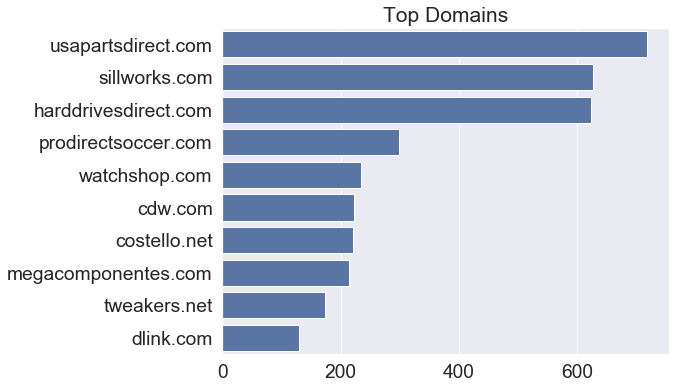

In [6]:
domains = train_test_offer_features.domain.str.replace('www\.|de\.', '')\
    .value_counts().head(10)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.75)

sns.barplot(x=domains.values, y=domains.index, 
            color="b")\
            .set_title('Top Domains')

### Offer Features

#### There are 10 offer features that comprise 4 broad feature types.

- 6 are short-to-medium free-text attributes
    - 4 of them are types of indentifiers: gtin, mpm, sku and a generic identifier
    - 2 of them are the brand and manufacturer

- The offer name is the medium-length text attributes
    
- The description is a longer free-text attribute

- The price is a numeric feature

In [88]:
SHORT_TEXT_FEATURES = ['gtin', 'mpn', 'sku', 'identifier', 'brand', 'manufacturer']
MEDIUM_LONG_TEXT_FEATURES = ['name', 'description']
OTHER_FEATURES = ['price']
ALL_FEATURES = SHORT_TEXT_FEATURES + MEDIUM_LONG_TEXT_FEATURES + OTHER_FEATURES
OFFER_PAIR_COLUMNS = ['offer_id_1', 'offer_id_2', 'filename', 'dataset', 'label', 'file_category']
                  
train_test_offer_features_only = train_test_offer_features[ALL_FEATURES]
test_offer_features_only = train_test_offer_features.loc[train_test_offer_features.offer_id.isin(test_ids), ALL_FEATURES]

display(HTML(train_test_offer_features_only.head(3).to_html(index=False)))


gtin,mpn,sku,identifier,brand,manufacturer,name,description,price
NaN,672631b21,NaN,NaN,hp enterprise,NaN,672631 b21 hp 16gb 1x16gb sdram dimm,hp 16gb 1x16gb dual rank x4 pc3 12800r ddr3 1600 registered cas 11 memory kitpart number s option part 672631 b21 hp smartbuy part 672631 s21 spare part 684031 001 assembly part 672612 081,155.94
NaN,672631b21,NaN,NaN,hp enterprise,NaN,672631 b21 hp 16gb 1x16gb sdram dimm,hp 16gb 1x16gb dual rank x4 pc3 12800r ddr3 1600 registered cas 11 memory kitpart number s option part 672631 b21 hp smartbuy part 672631 s21 spare part 684031 001 assembly part 672612 081,155.94
NaN,NaN,NaN,NaN,NaN,hp,hp 16gb ddr3 sdram memory module 16 gb 1 x 16 gb ddr3 sdram 1600 mhz ddr3 1600 pc3 12800 registereddimm,NaN,NaN


### Feature Sparsity

In [8]:
null_percentages = calculate_percent_nulls(train_test_offer_features_only, print_series=False, return_series=True)
nulls_by_index = train_test_offer_features[null_percentages.index].isnull().T

Text(0.5,1,'% Missing Values')

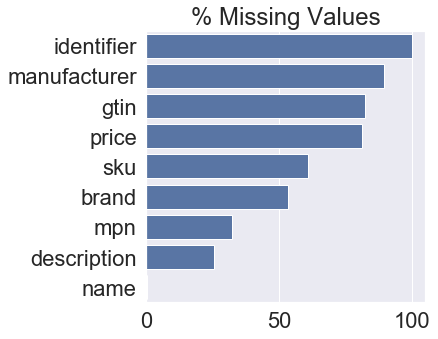

In [9]:
plt.figure(figsize=(5, 5))
sns.set(font_scale=2)

sns.barplot(x=null_percentages.values, 
            y=null_percentages.index, 
            color="b")\
            .set_title('% Missing Values')

Text(0.5,1,'Figure 3. Missing Value Correlation')

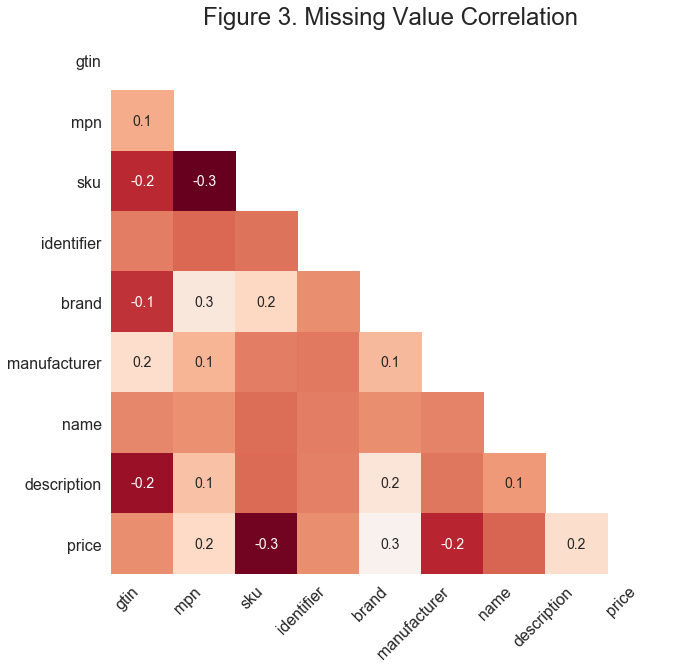

In [10]:
sns.set(font_scale=2)
msno.heatmap(train_test_offer_features_only, figsize=(10, 10)).set_title("Figure 3. Missing Value Correlation")



### Text Lengths



In [11]:
# count words
medium_long_features = train_test_normalized_features[MEDIUM_LONG_TEXT_FEATURES]
word_counts_df = medium_long_features.apply(count_words, axis=1)

[None]

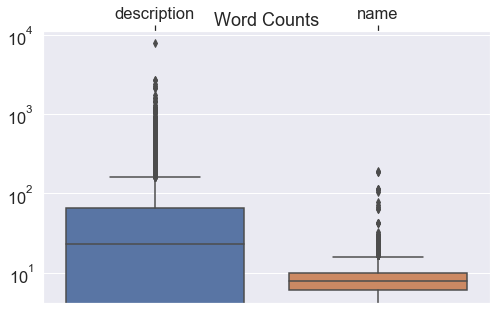

In [12]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.5)

ax = sns.boxplot(data = word_counts_df)
ax.set_title('Word Counts')
ax.xaxis.tick_top()
ax.set(yscale='log')

In [13]:
# count chararters for short-text features
short_text_features = train_test_normalized_features[SHORT_TEXT_FEATURES]
char_counts_df = short_text_features.apply(lambda s: s.str.len(), axis=1)

[None]

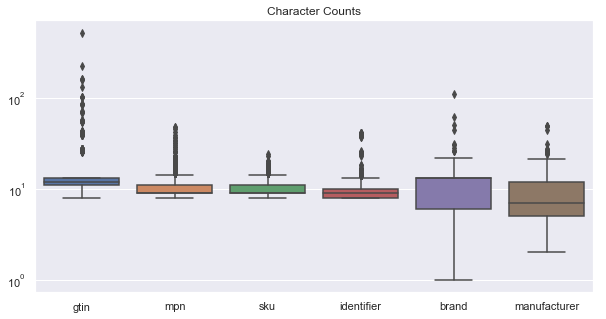

In [14]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1)

ax = sns.boxplot(data = char_counts_df)
ax.set_title('Character Counts')
ax.set(yscale='log')

### Top Values by Attribute

In [15]:
top_values =\
    train_test_normalized_features[['brand', 'manufacturer']]\
        .melt()\
        .dropna().groupby(['variable', 'value'])['value'].agg('count')\
        .to_frame()\
        .rename(index=str, columns={'value': 'value_counts'})\
        .reset_index()\
        .groupby(['variable'])\
        .apply(lambda x: x.nlargest(10, 'value_counts'))\
        .reset_index(drop=True)

top_values['value'] = top_values.value.str.slice(stop=25)

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


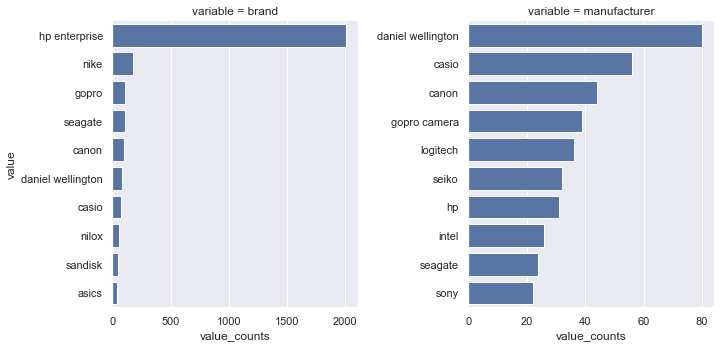

In [16]:
g = sns.FacetGrid(top_values, col="variable", col_wrap=5, sharey=False, sharex=False)
g.fig.set_figwidth(25)
g.fig.set_figheight(5)

g.map(sns.barplot, 'value_counts', 'value')

### Unique Value Counts

In [17]:
unique_values = train_test_normalized_features[ALL_FEATURES].apply(pd.Series.nunique, axis=0).sort_values(ascending=False)

Text(0.5,1,'Unique Values')

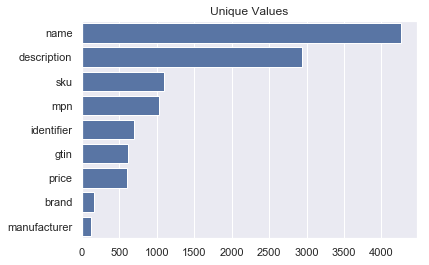

In [18]:
sns.barplot(x = unique_values, y=unique_values.index, 
            color="b")\
            .set_title('Unique Values')

### Training & Testing Data Characteristics

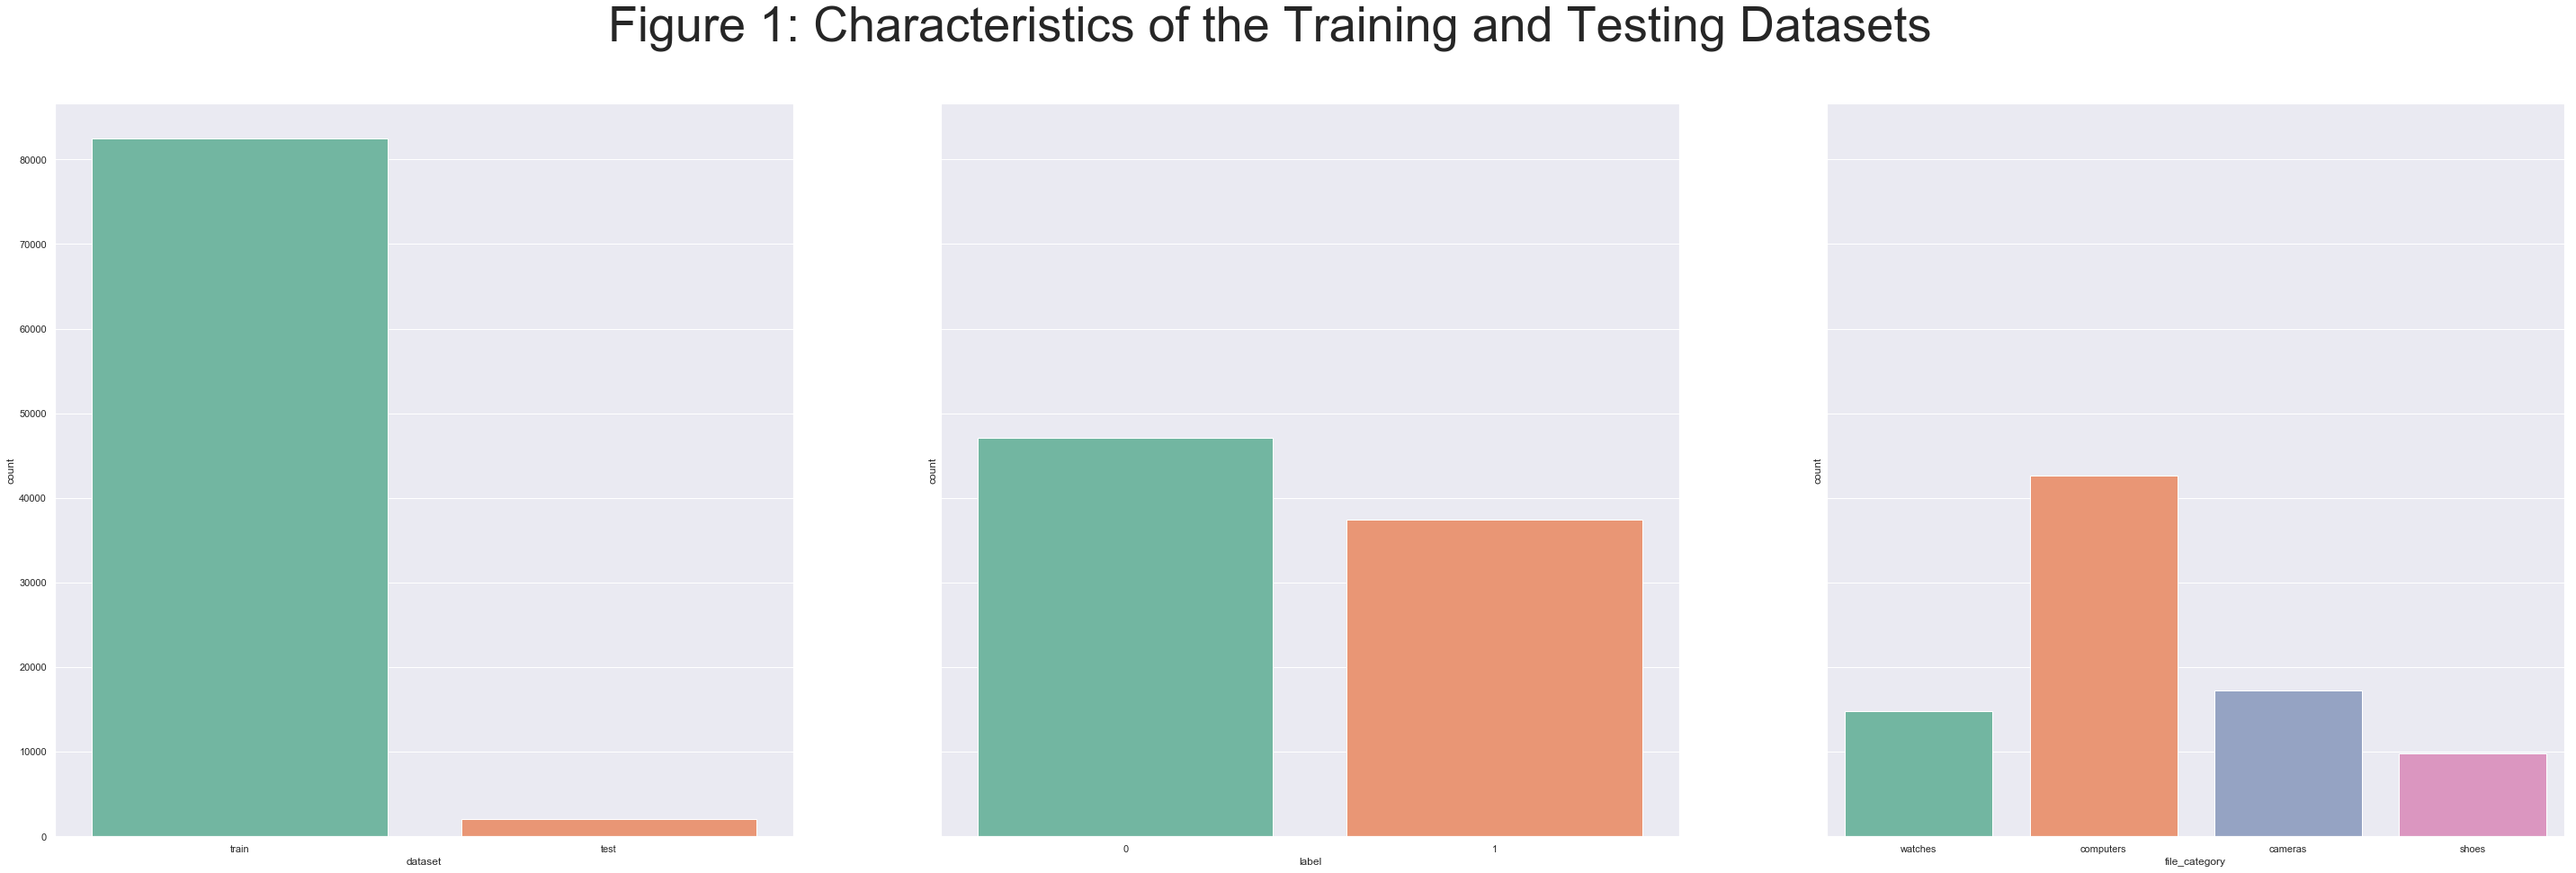

In [19]:
test_train_characteristics = train_test_feature_pairs[['label', 'dataset', 'file_category']]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(50, 15), sharey=True) 

sns.set(font_scale=2)
plt.rcParams.update({'font.size': 45})
st = fig.suptitle("Figure 1: Characteristics of the Training and Testing Datasets")

sns.countplot(x='dataset', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[0])

# mosaic plot: https://www.statsmodels.org/dev/generated/statsmodels.graphics.mosaicplot.mosaic.html
sns.countplot(x='label', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[1])

sns.countplot(x='file_category', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[2])

### Testing Data Characteristics


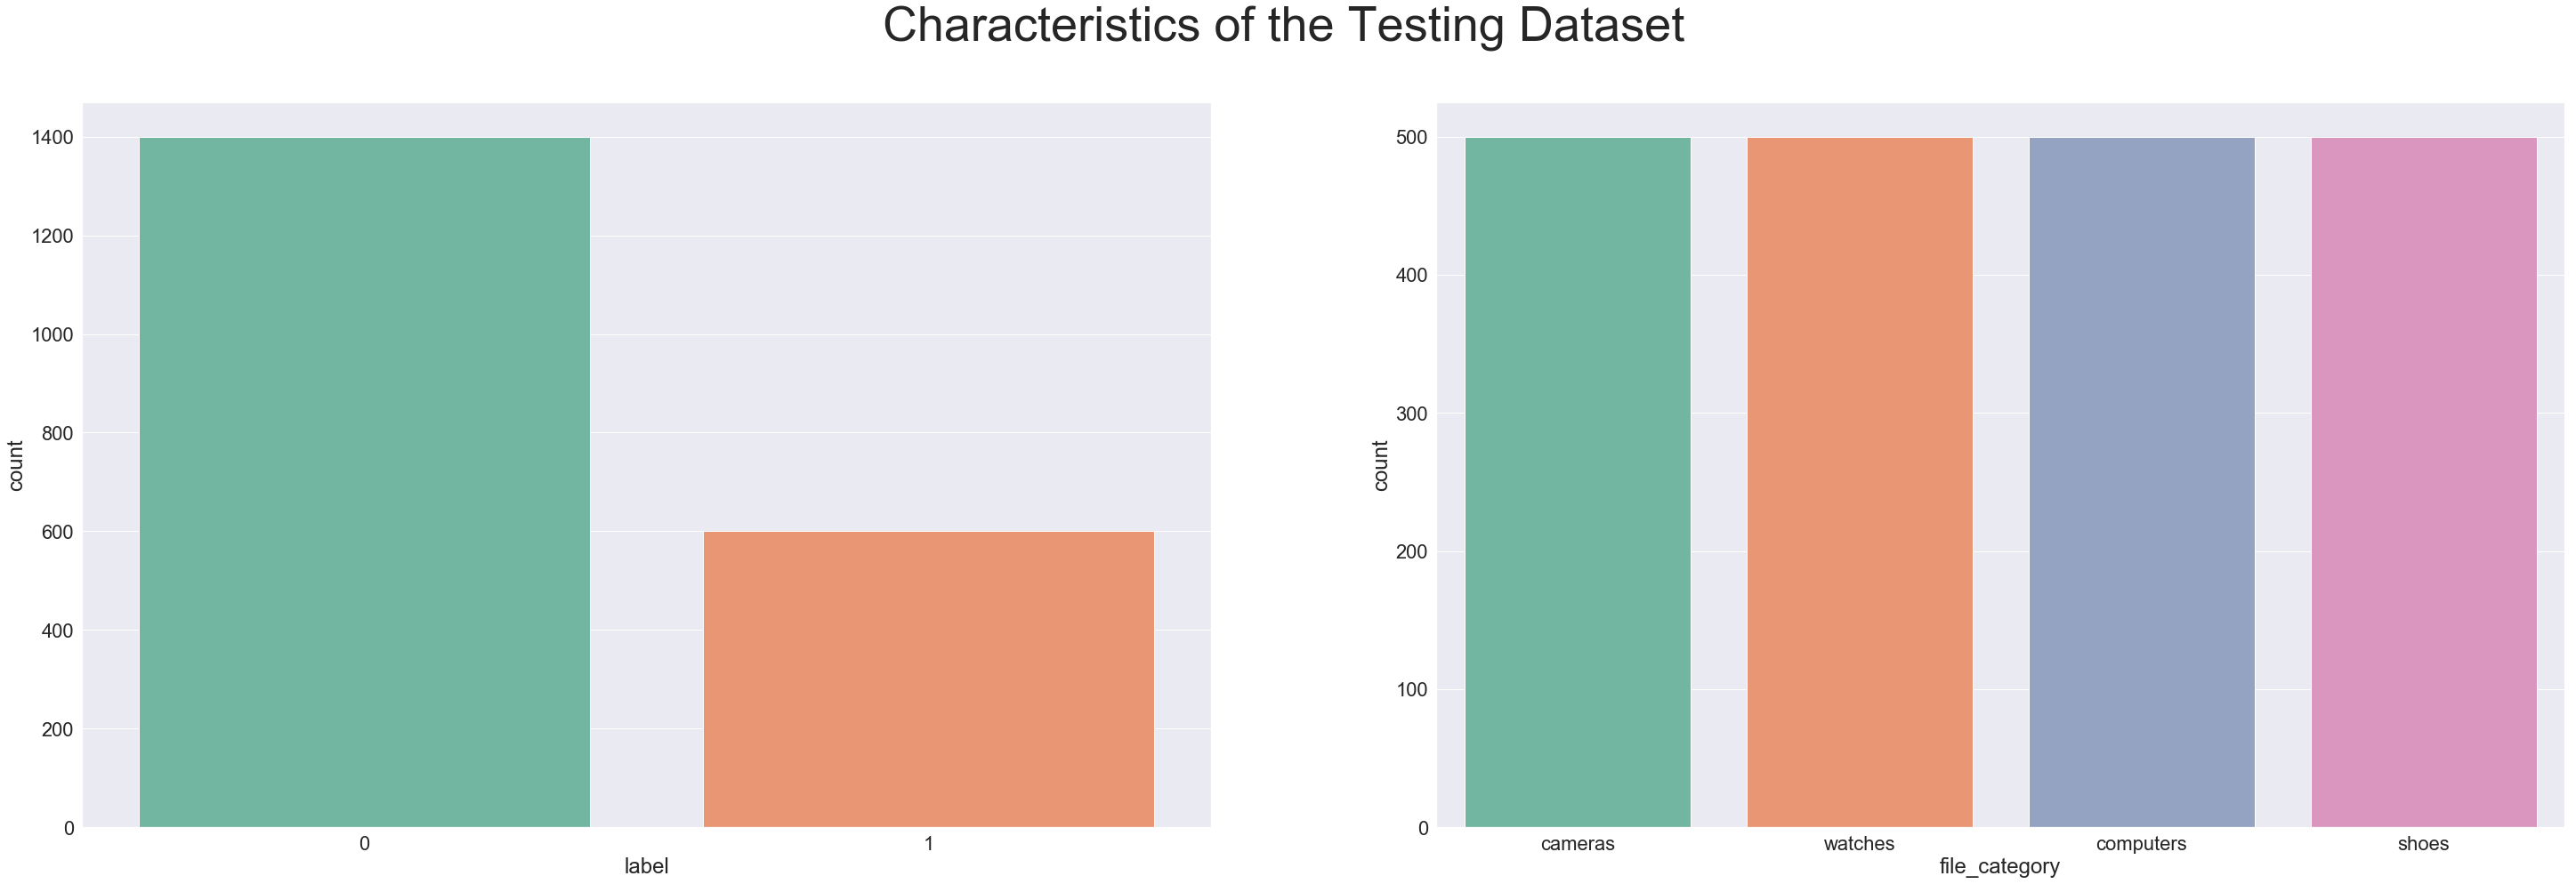

In [20]:
test_characteristics = test_train_characteristics[test_train_characteristics.dataset == 'test']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15)) #

sns.set(font_scale=4)
plt.rcParams.update({'font.size': 45})
st = fig.suptitle("Characteristics of the Testing Dataset")

sns.countplot(x='label', data=test_characteristics, palette=sns.color_palette("Set2"), ax=axes[0])

sns.countplot(x='file_category', data=test_characteristics, palette=sns.color_palette("Set2"), ax=axes[1])

### Feature Sets

1. Attribute Comparison Features: Measured the similarity between each offer pair's attribute values

    a. Levenshtein distance
    
    b. Bag-of-words & cosine similarity
    


2. Single Document Features
    
    a. Concatenated all features into a single string
    
    b. Encoded the attributes using TF-IDF bag-of-words
    
    c. Reduced the dimensionality using truncated SVD
    
    d. Absolute difference between the vectors



### Feature Analysis

#### Feature Correlation

In [21]:
feature_corr = attribute_comp_features_9.corr()

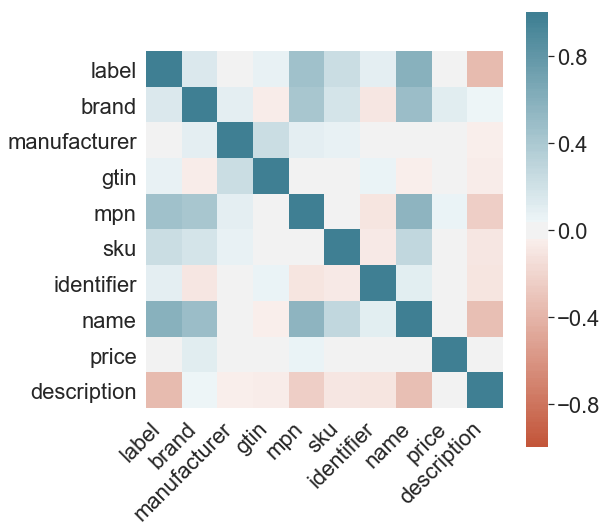

In [22]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=2)

ax = sns.heatmap(
    feature_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

# ax.set_title('Correlation')
settings =\
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

# source: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

#### Feature Importance

In [23]:
var_imp = var_imp_coef.Overall.sort_values(ascending=False)
var_coef = var_imp_coef.Coefficient.sort_values(ascending=False)

<Figure size 576x1440 with 0 Axes>

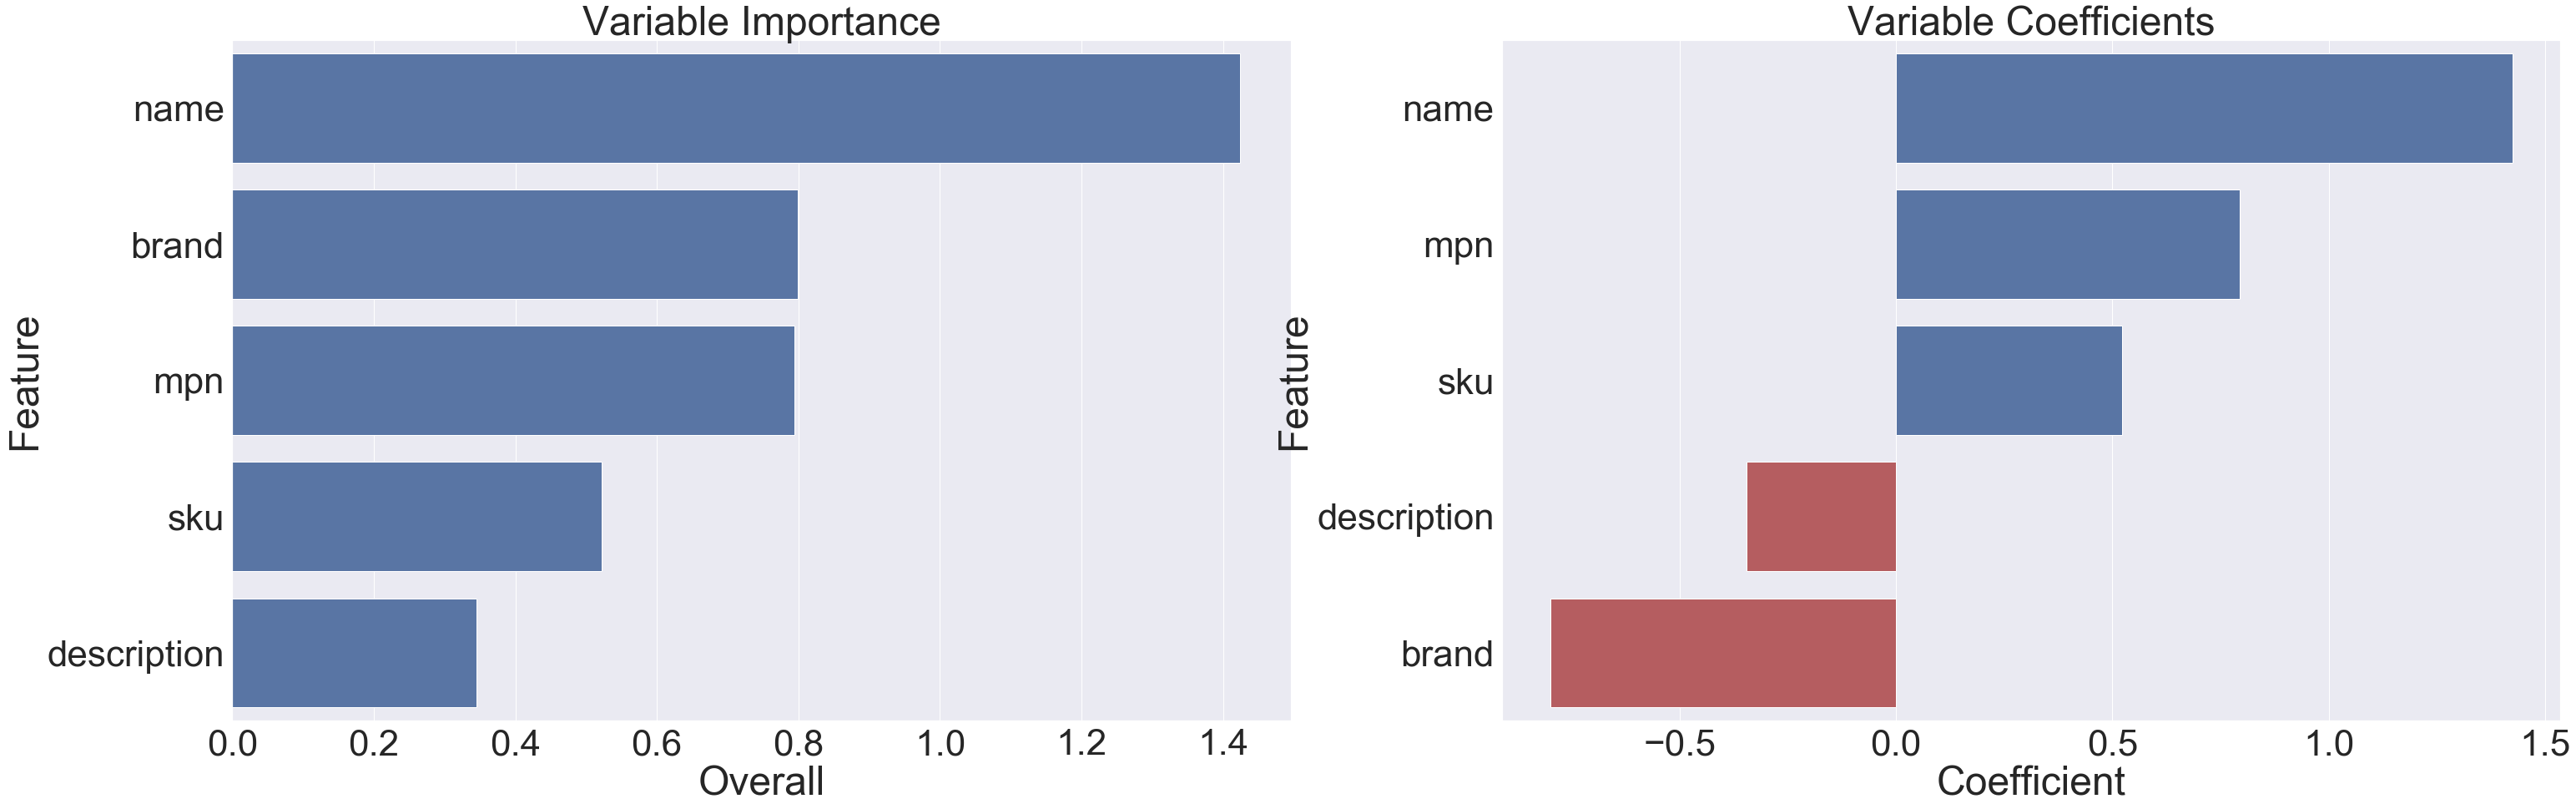

In [24]:
plt.figure(figsize=(8, 20))
sns.set(font_scale=4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15))
sns.barplot(x=var_imp, 
            y=var_imp.index, 
            color="b", 
            ax=axes[0])\
            .set_title('Variable Importance')



sns.barplot(x=var_coef, 
            y=var_coef.index, 
            palette=var_coef.apply(lambda x: 'b' if x > 0 else 'r'),
            ax=axes[1])

t2 = axes[1].set_title('Variable Coefficients')

### Pairs Plot

In [99]:
attribute_comp_features_9_feat_label = attribute_comp_features_9[ALL_FEATURES + ['label']]

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


Text(0.5,1.08,'Pair Plot')

<Figure size 864x864 with 0 Axes>

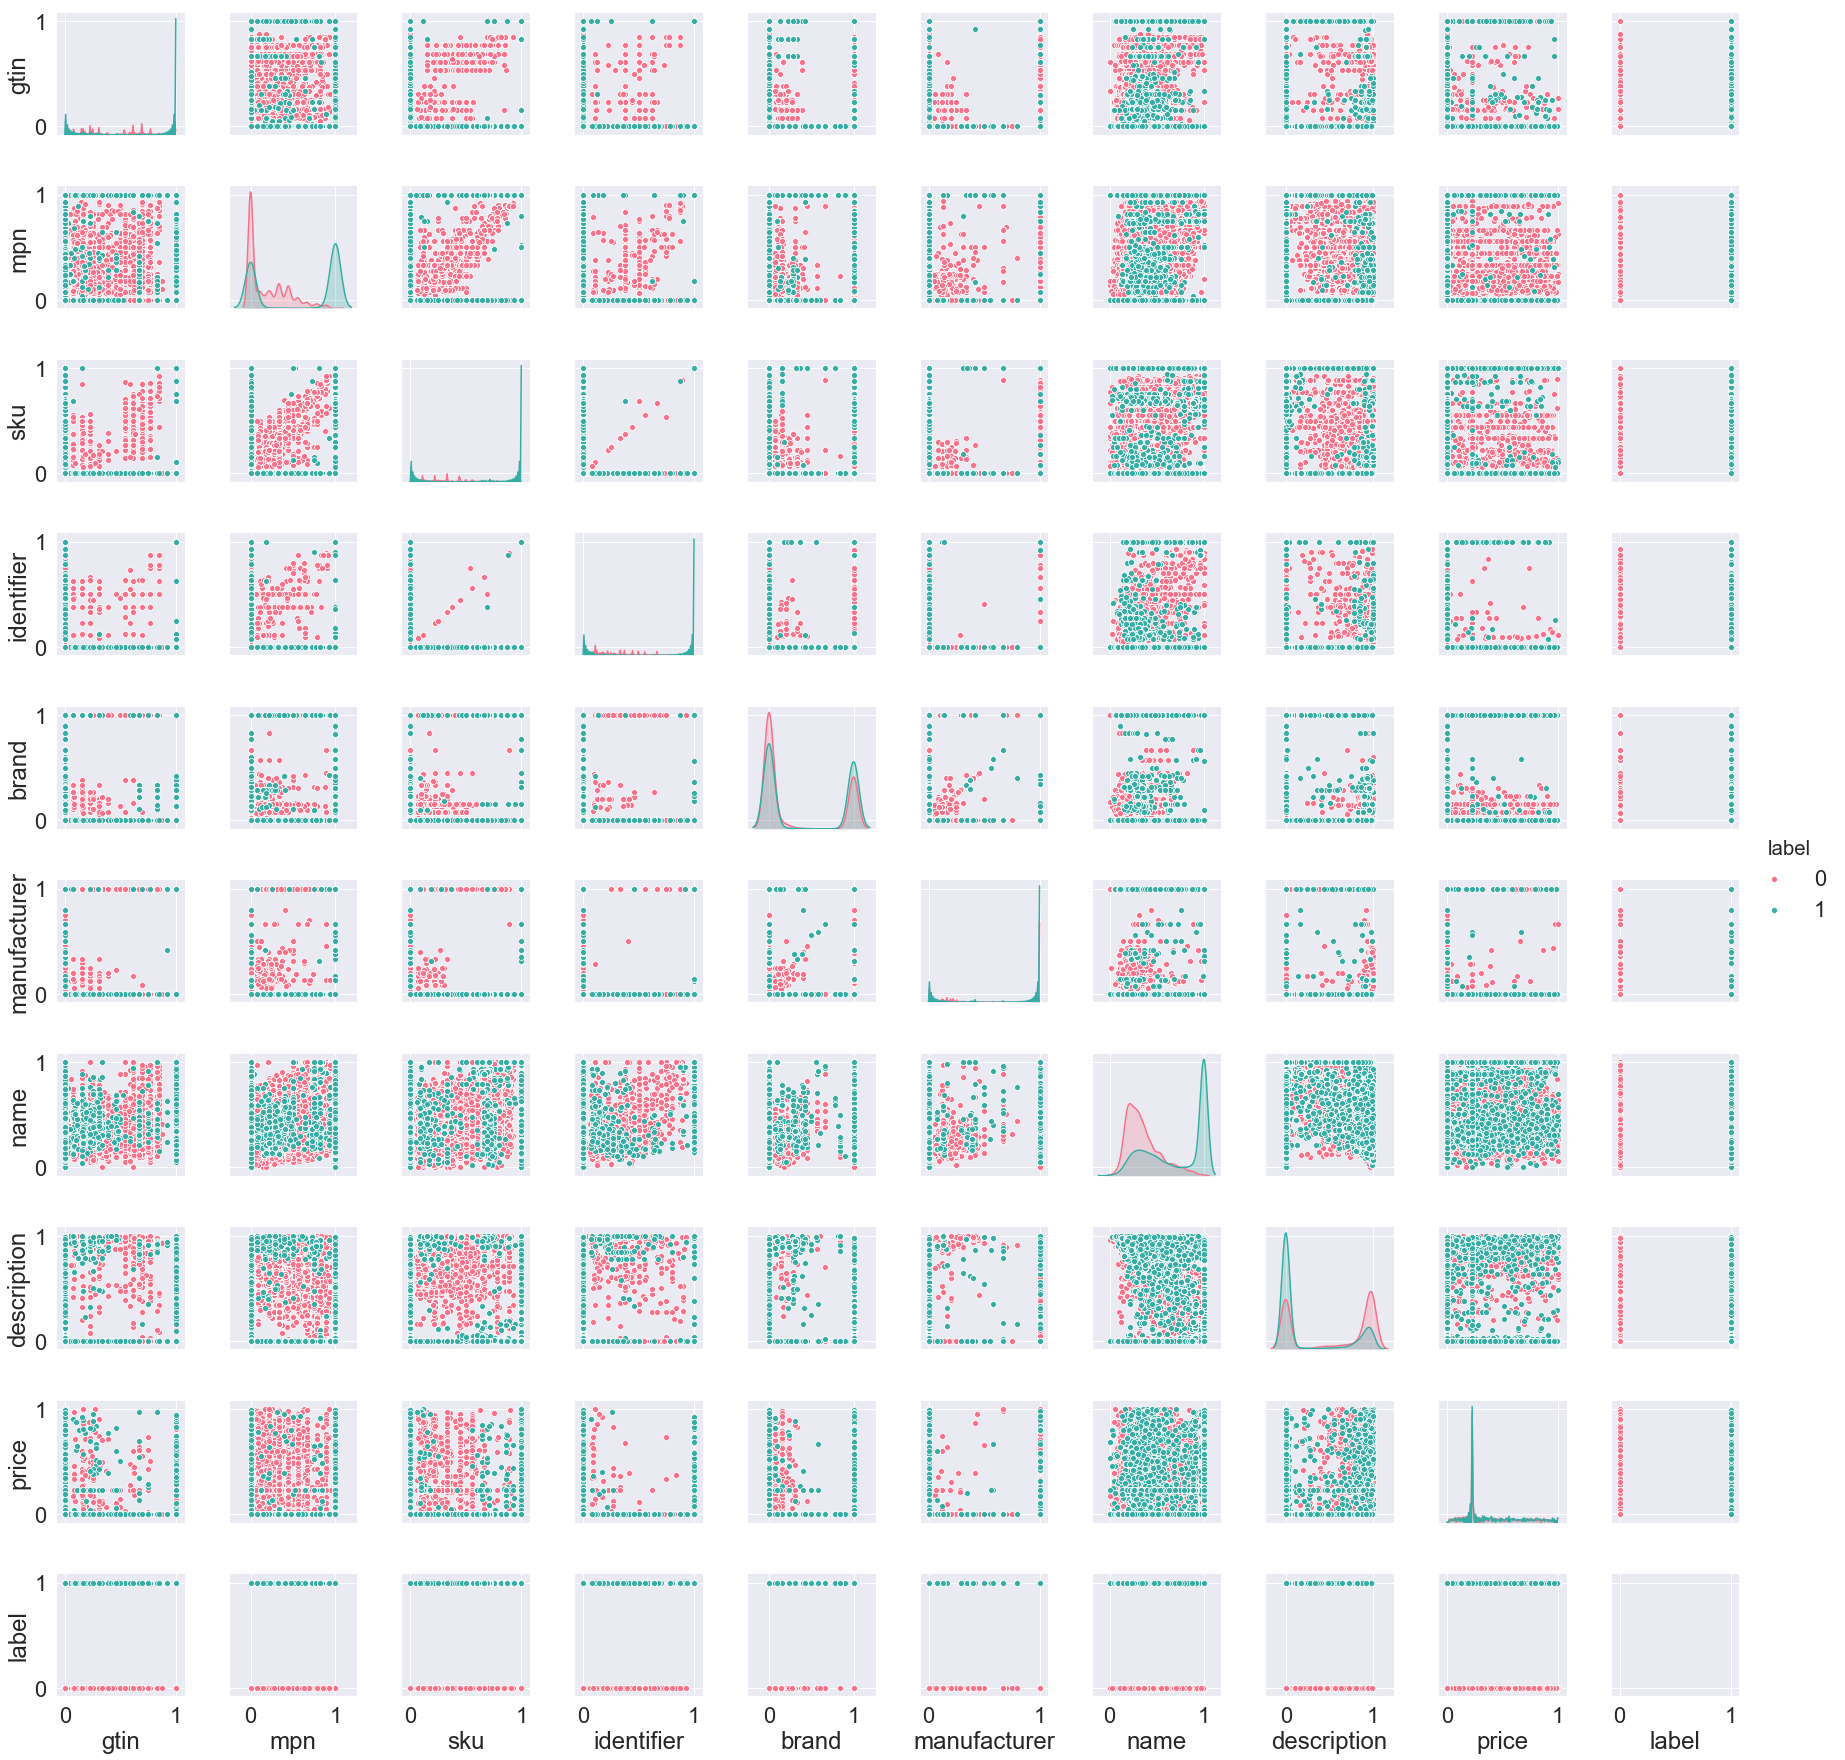

In [154]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=2)
sns.pairplot(attribute_comp_features_9_feat_label, hue='label', palette="husl")
g.fig.suptitle("Pair Plot", y=1.08)

### Side-by-Side Boxplots

In [141]:
attribute_comp_features_9_feat_label_melted = pd.melt(attribute_comp_features_9_feat_label, id_vars='label')

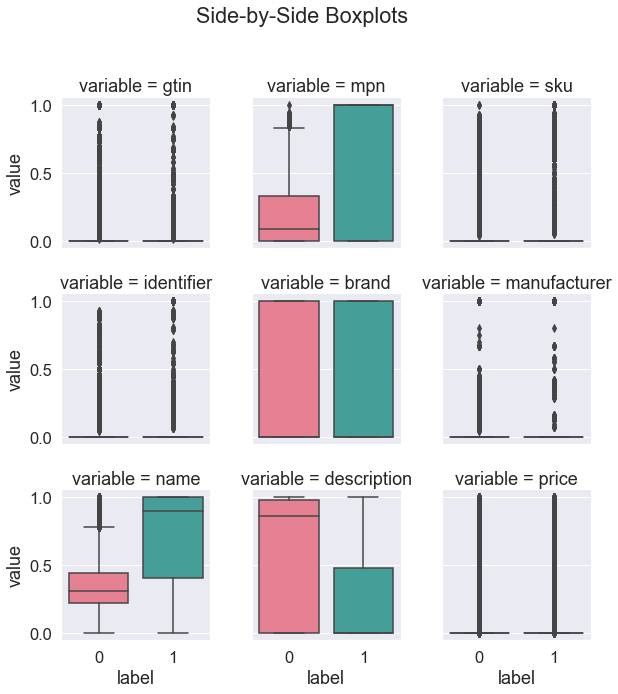

In [158]:
# plt.figure(figsize=(4, 4))
sns.set(font_scale=1.5)

g = sns.catplot(col="variable", 
                y='value',
                x="label",
                data=attribute_comp_features_9_feat_label_melted,
                palette="husl", 
                col_wrap=3,
                kind="box",
                height=3)

t = g.fig.suptitle('Side-by-Side Boxplots', y=1.08)

### Models

1.

2.

3.

4.

## Results

<h2><center>Results</center></h2>




![](https://github.com/kylegilde/Entity-Matching-in-Online-Retail/blob/master/plots/results-table.PNG?raw=true)

In [25]:
# get variable importance
rf_acf9 = acf9_models[2].best_estimator_ 
input_feature_order = ['brand', 'manufacturer', 'gtin', 'mpn', 'sku', 'identifier', 'name', 'price', 'description']

var_imp_rf = pd.DataFrame({'feature': input_feature_order,
                           'importance': rf_acf9.feature_importances_})\
    .set_index('feature').sort_values('importance', ascending=False)

sgb_acf9 = acf9_models[3].best_estimator_ 
var_imp_sgb = pd.DataFrame({'feature': input_feature_order,
                           'importance': sgb_acf9.feature_importances_})\
    .set_index('feature').sort_values('importance', ascending=False)

<Figure size 720x2880 with 0 Axes>

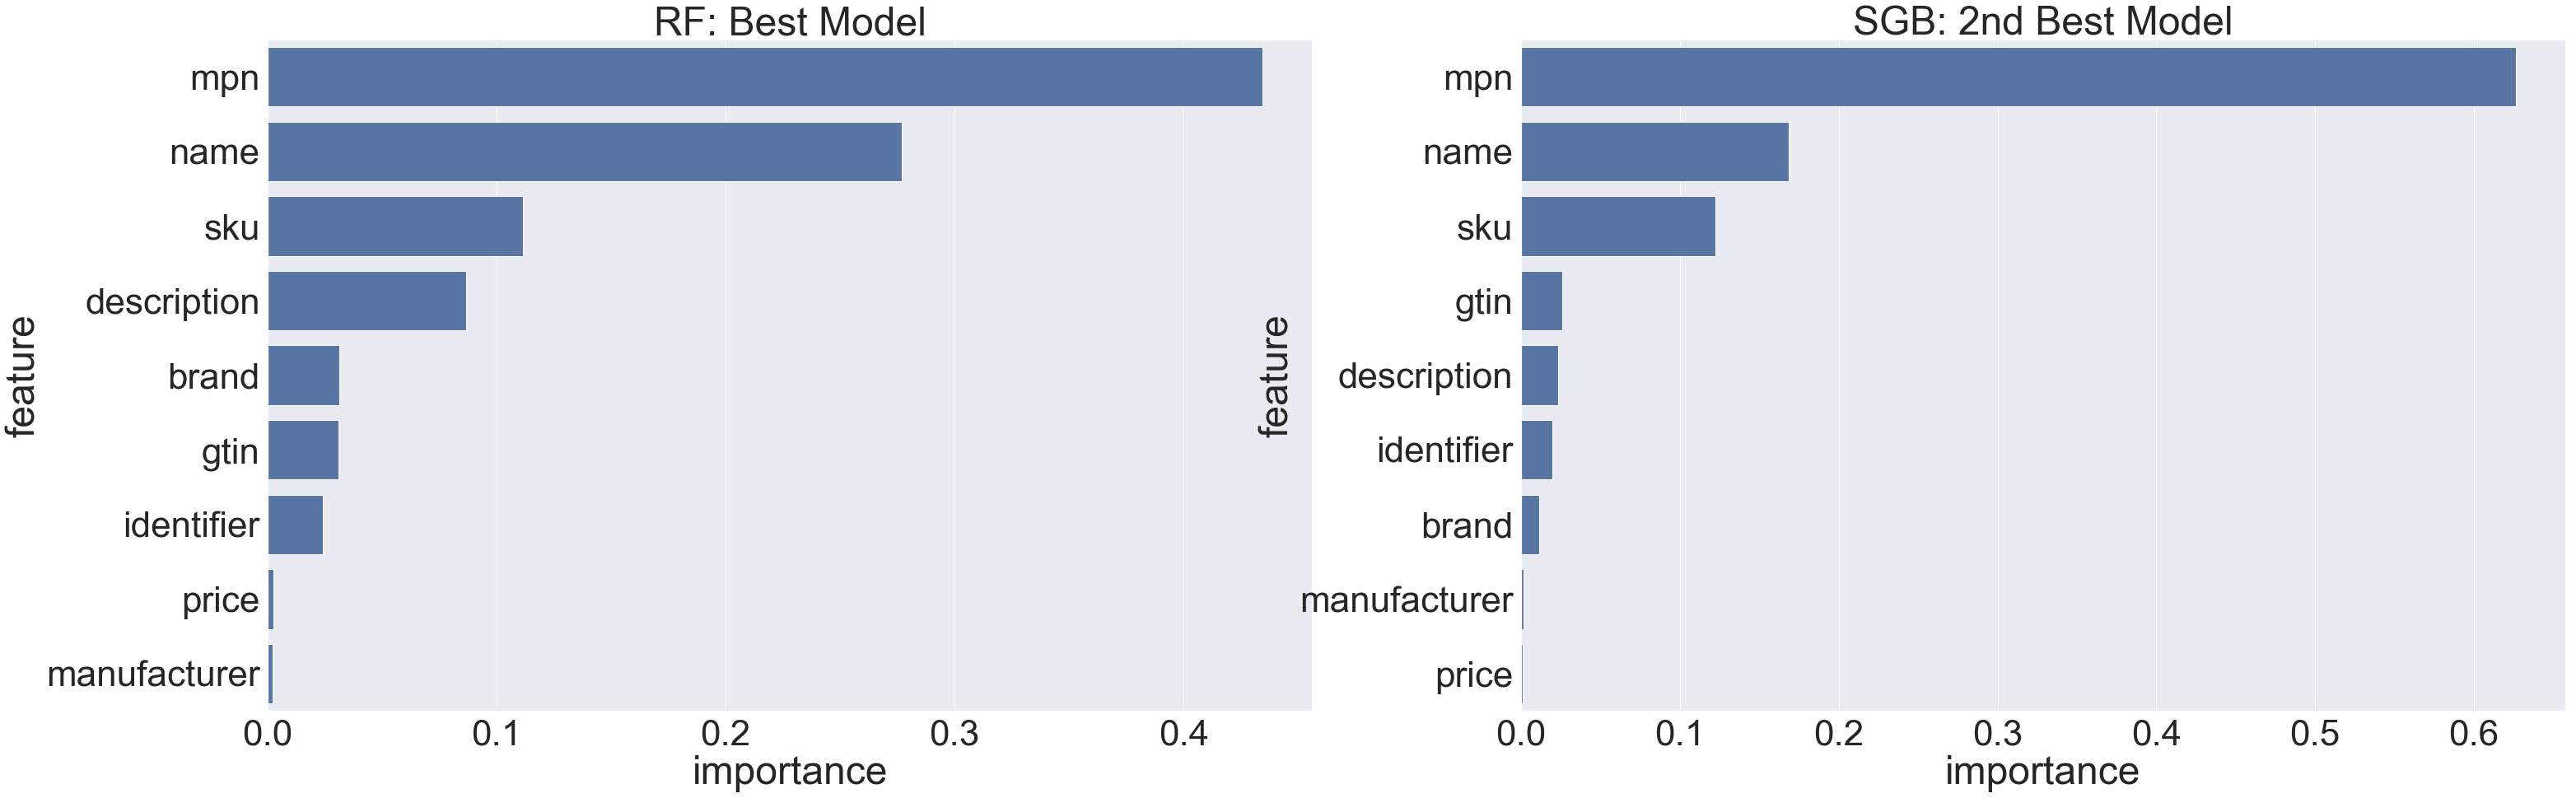

In [26]:
# plot variable importance
plt.figure(figsize=(10, 40))
sns.set(font_scale=4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15))

sns.barplot(x=var_imp_rf.importance,
           y=var_imp_rf.index,
           color='b',
           ax=axes[0])\
            .set_title('RF: Best Model')

sns.barplot(x=var_imp_sgb.importance,
           y=var_imp_sgb.index,
           color='b',
           ax=axes[1])

t2 = axes[1].set_title('SGB: 2nd Best Model')

### Precision and Recall

#### Top Model

In [27]:
# create the curve data
test_labels = attribute_comp_features_9.loc[attribute_comp_features_9.dataset == 'test', 'label']
precision, recall, thresholds = precision_recall_curve(test_labels, acf9_rf_class_proba[:, 1])
thresholds = np.append(thresholds, 1) 

pr_curve_df = pd.DataFrame({'Precision': precision, 
                            'Recall': recall,
                            'Threshold': thresholds})

pr_curve_df['Delta'] = np.abs(pr_curve_df.Precision - pr_curve_df.Recall)
pr_curve_df_melted = pd.melt(pr_curve_df.iloc[:, :3], id_vars='Threshold')

# AUC
auc_score = auc(pr_curve_df.Recall, pr_curve_df.Precision)

In [28]:
perfect_precision, perfect_recall, equal_scores =\
    pr_curve_df[pr_curve_df.Precision == 1].iloc[0],\
    pr_curve_df[pr_curve_df.Recall == 1].iloc[0],\
    pr_curve_df[pr_curve_df.Delta == np.min(pr_curve_df.Delta)].iloc[0]

# print(perfect_precision, perfect_recall, equal_scores)
thresholds_df = pd.concat([perfect_precision, perfect_recall, equal_scores], 
                          axis=1, 
                          ignore_index=True).T\
    .drop('Delta', axis=1)\
    .round(3)

display(HTML(thresholds_df.to_html(index=False)))

# from sklearn.metrics import average_precision_score
# average_precision_score(test_labels, acf9_rf_pred)

Precision,Recall,Threshold
1.000,0.296,0.999
0.376,1.000,0.041
0.803,0.804,0.571


0.6810063941941052

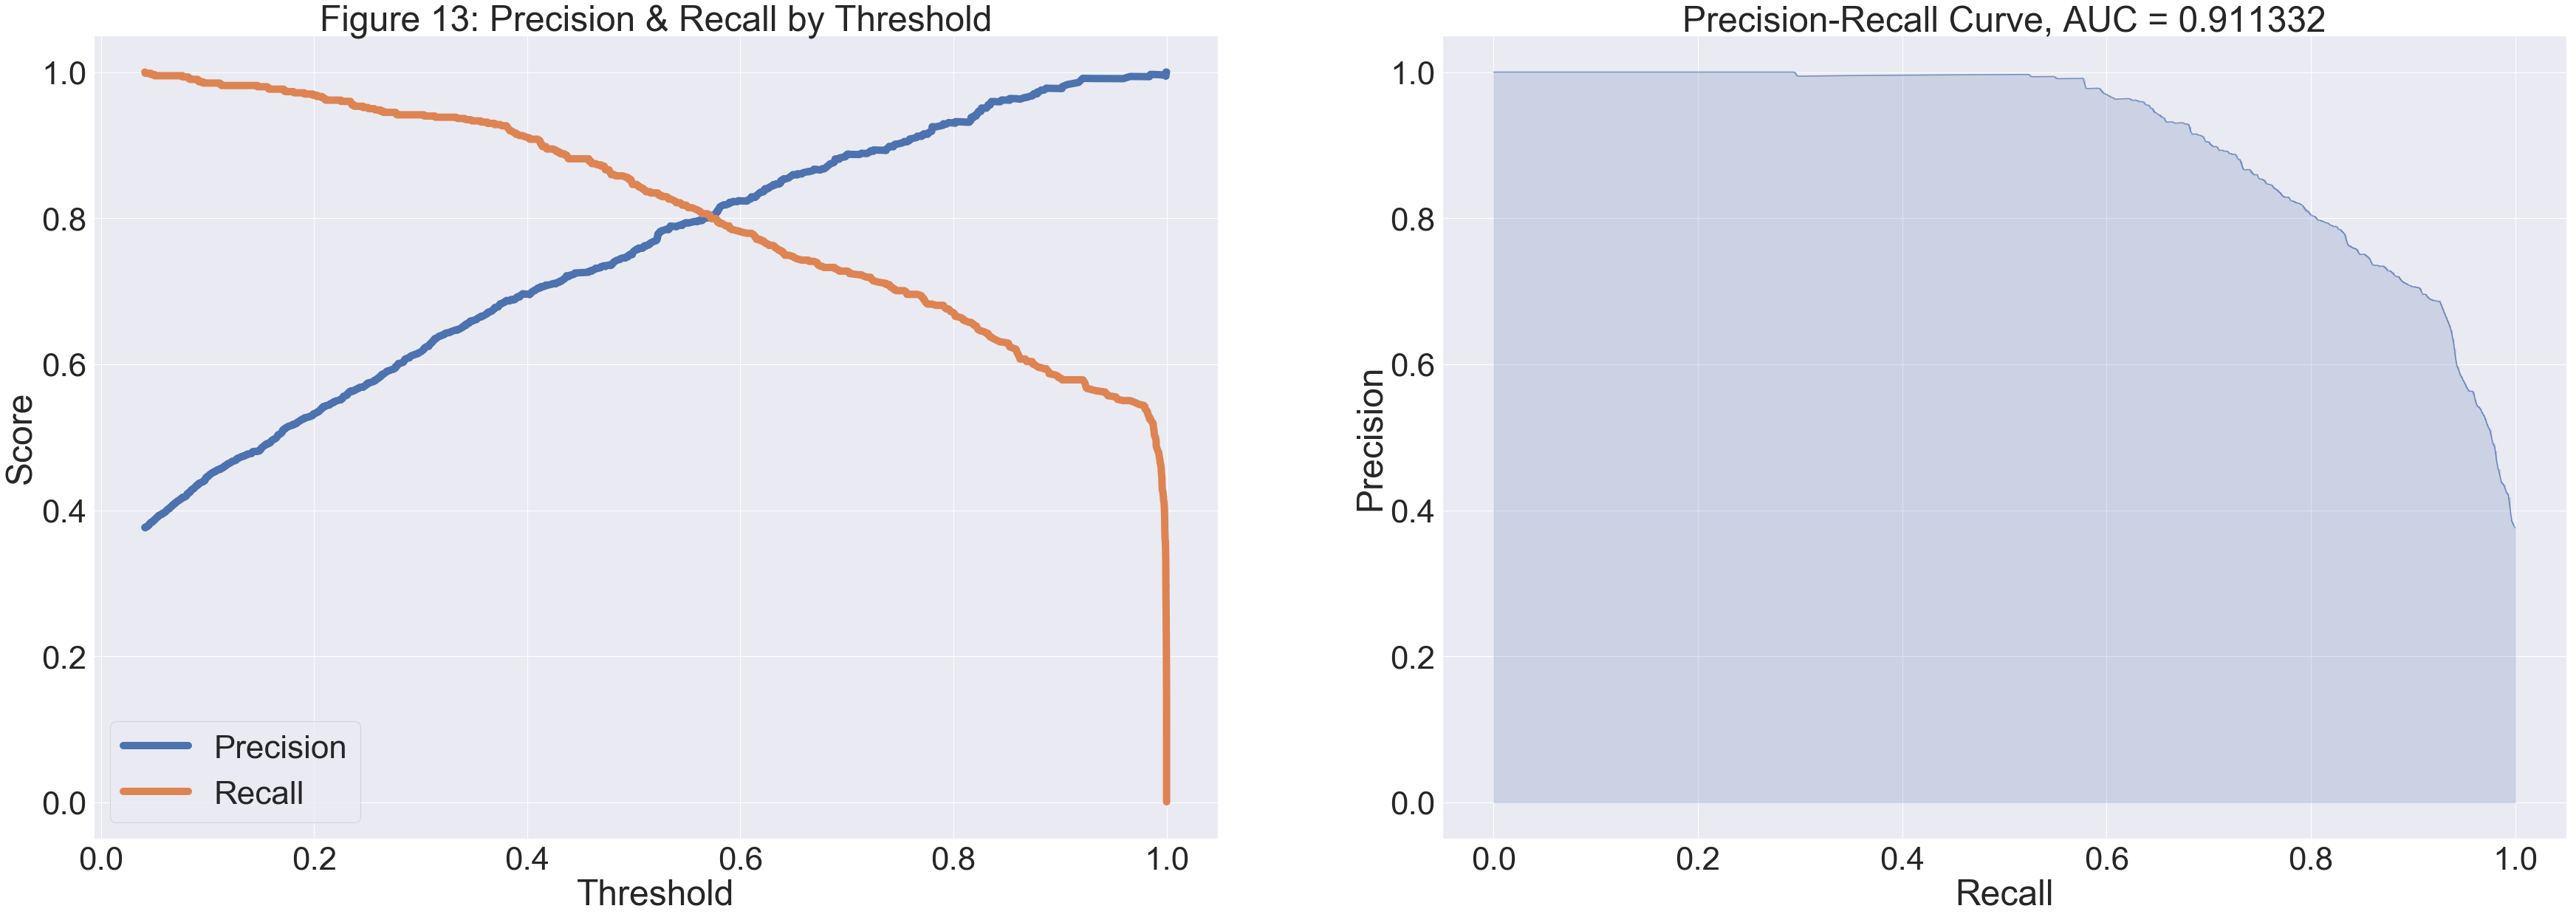

In [29]:
sns.set(font_scale=4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(60, 20))

# plot 1
sns.lineplot(x='Threshold',
            y='value',
            hue='variable',
            data=pr_curve_df_melted,
            ax=axes[0], 
            linewidth=10)\
            .set_title('Figure 13: Precision & Recall by Threshold')

# plt.axvline(thresholds_df.loc[thresholds_df.Precision==1, 'Threshold'].astype('float'))
axes[0].legend(('Precision', 'Recall'), frameon=True) 
axes[0].set(ylabel='Score')

# plot 2
sns.lineplot(x='Recall',
             y='Precision',
             data=pr_curve_df, 
             alpha=.7,
             ax=axes[1])\
            .set_title('Precision-Recall Curve, AUC = %f' % auc_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

axes[1].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

#### 2nd Best Model

In [61]:
acf9_sgb_class_proba = pickle.load(open('sklearn_class_probabilities.pkl', 'rb'))[3]
acf9_sgb_pred = pickle.load(open('sklearn_test_predictions.pkl', 'rb'))[3]

# create the curve data
test_labels = attribute_comp_features_9.loc[attribute_comp_features_9.dataset == 'test', 'label']
precision, recall, thresholds = precision_recall_curve(test_labels, acf9_sgb_class_proba[:, 1])
thresholds = np.append(thresholds, 1) 

pr_curve_df_2 = pd.DataFrame({'Precision': precision, 
                            'Recall': recall,
                            'Threshold': thresholds})

pr_curve_df_2['Delta'] = np.abs(pr_curve_df_2.Precision - pr_curve_df_2.Recall)
pr_curve_df_melted_2 = pd.melt(pr_curve_df_2.iloc[:, :3], id_vars='Threshold')

# AUC
auc_score = auc(pr_curve_df_2.Recall, pr_curve_df_2.Precision)

In [56]:
perfect_precision, perfect_recall, equal_scores =\
    pr_curve_df[pr_curve_df_2.Precision == 1].iloc[0],\
    pr_curve_df[pr_curve_df_2.Recall == 1].iloc[0],\
    pr_curve_df[pr_curve_df_2.Delta == np.min(pr_curve_df_2.Delta)].iloc[0]

# print(perfect_precision, perfect_recall, equal_scores)
thresholds_df_2 = pd.concat([perfect_precision, perfect_recall, equal_scores], 
                          axis=1, 
                          ignore_index=True).T\
    .drop('Delta', axis=1)\
    .round(3)

display(HTML(thresholds_df_2.to_html(index=False)))


C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Precision,Recall,Threshold
1.000,0.211,1.000
0.376,1.000,0.041
0.882,0.727,0.693


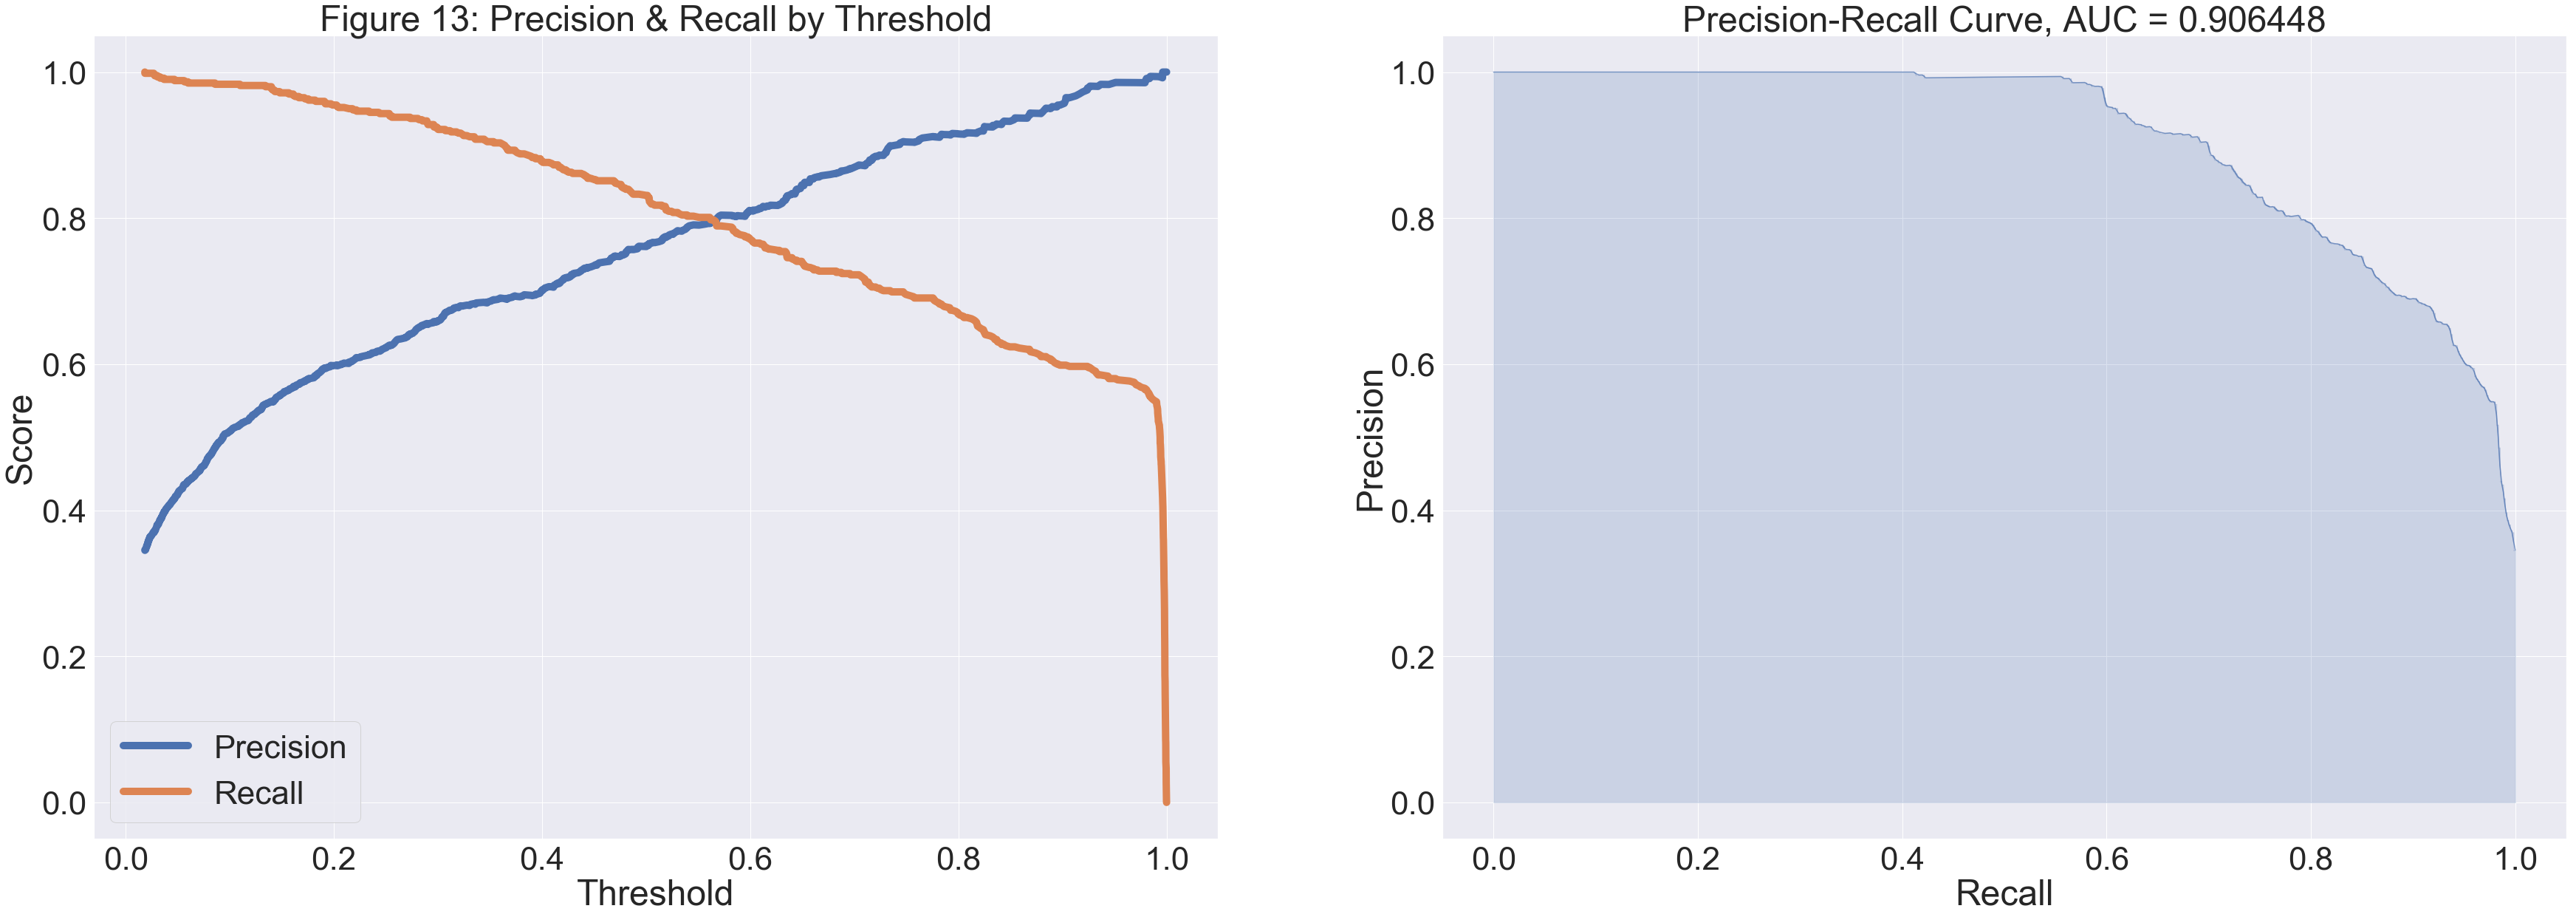

In [55]:
sns.set(font_scale=4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(60, 20))

# plot 1
sns.lineplot(x='Threshold',
            y='value',
            hue='variable',
            data=pr_curve_df_melted_2,
            ax=axes[0], 
            linewidth=10)\
            .set_title('Figure 13: Precision & Recall by Threshold')

# plt.axvline(thresholds_df.loc[thresholds_df.Precision==1, 'Threshold'].astype('float'))
axes[0].legend(('Precision', 'Recall'), frameon=True) 
axes[0].set(ylabel='Score')

# plot 2
sns.lineplot(x='Recall',
             y='Precision',
             data=pr_curve_df_2, 
             alpha=.7,
             ax=axes[1])\
            .set_title('Precision-Recall Curve, AUC = %f' % auc_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

axes[1].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

### Performance by Model

In [30]:
# get metrics
model_avgs_melted = pd.melt(model_avgs, id_vars='Model', var_name='Metric', value_name='Score')

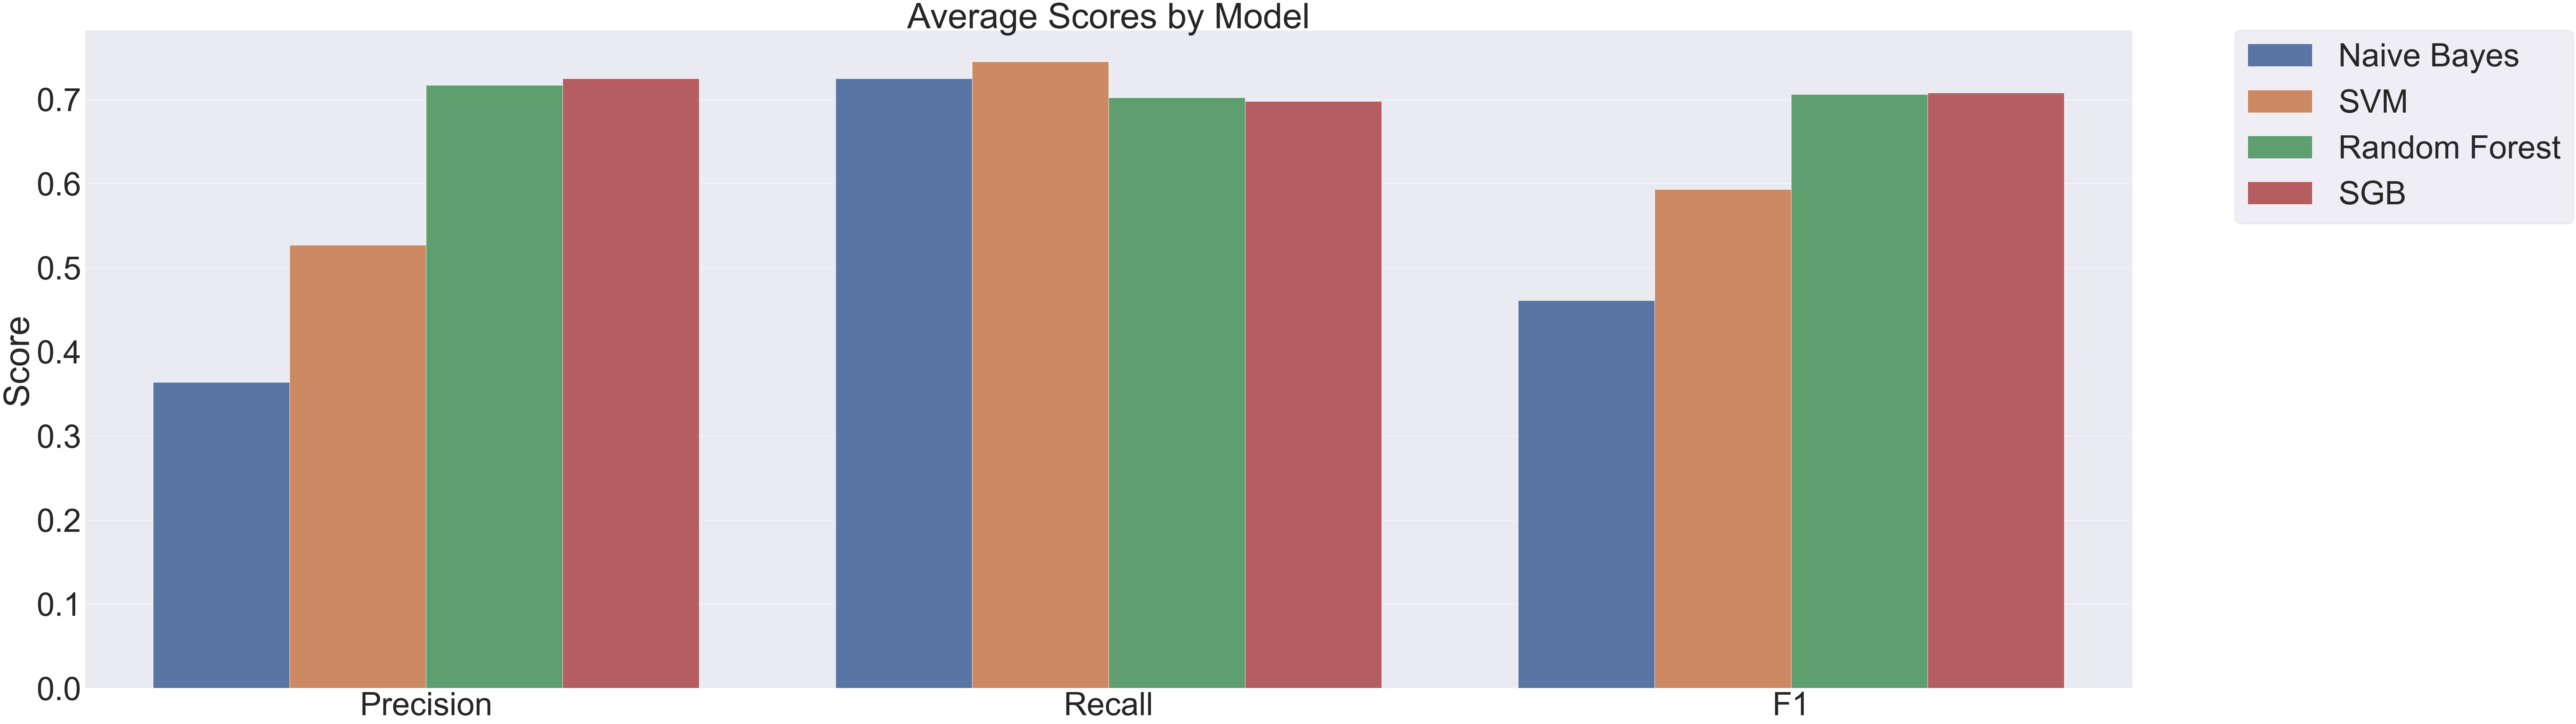

In [31]:
sns.set(font_scale=8)
plt.figure(figsize=(100, 33))

sns.barplot(x='Metric', 
            y='Score',
            hue='Model', 
            data=model_avgs_melted).set_title('Average Scores by Model')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

b = plt.xlabel('')

### Performance by Feature Set

In [32]:
feature_avgs_melted = pd.melt(feature_avgs, id_vars='Feature Set', var_name='Metric', value_name='Score')


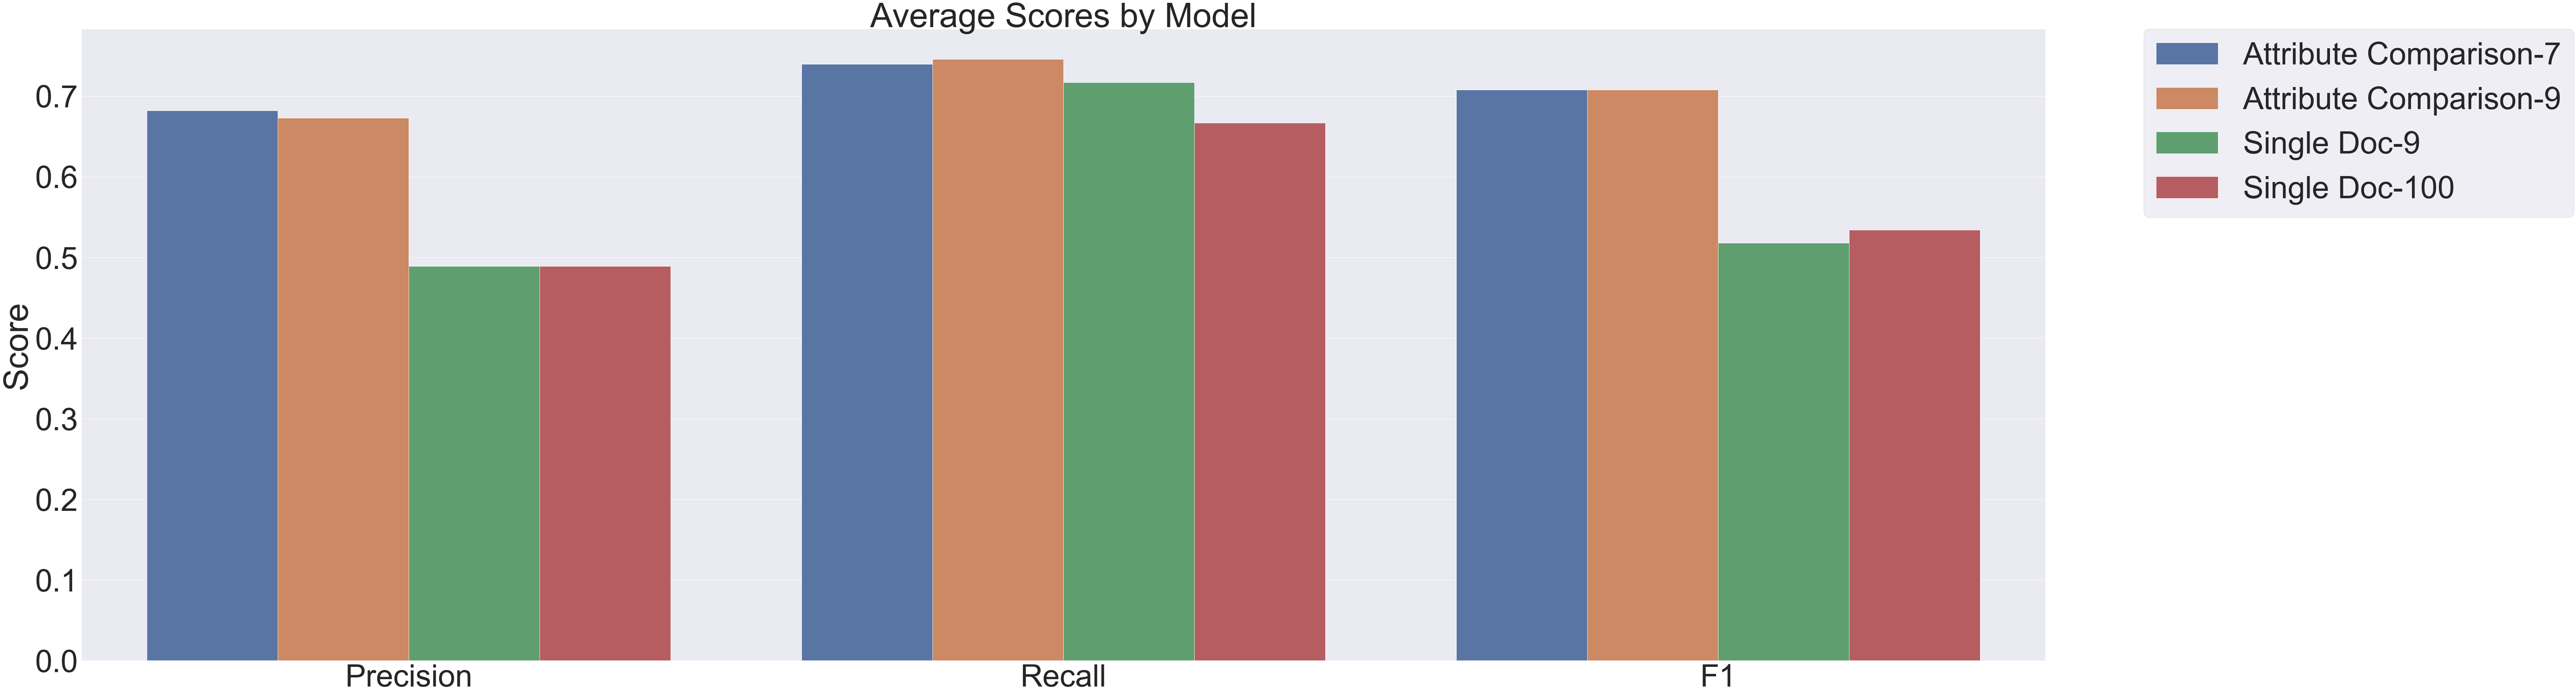

In [33]:
sns.set(font_scale=8)
plt.figure(figsize=(100, 33))

sns.barplot(x='Metric', 
            y='Score',
            hue='Feature Set', 
            data=feature_avgs_melted).set_title('Average Scores by Model')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
b = plt.xlabel('')

### Confusion Matrix


In [34]:
os.chdir(DATA_DIRECTORY + '/attribute_comparison_features-9')
acf9_cms = pickle.load(open('sklearn_confusion_matrices.pkl', 'rb'))
rf_conf_mat = acf9_cms[2]


rf_conf_mat_pct = np.round(rf_conf_mat / np.sum(rf_conf_mat.values) * 100, 1)
rf_conf_mat_pct
rf_conf_mat

,Predicted Class 0,Predicted Class 1
Class 0,1430,164
Class 1,92,506


### Performance by Category

In [41]:
test_categories = attribute_comp_features_9.loc[attribute_comp_features_9.dataset == 'test', 'file_category']
train_categories = attribute_comp_features_9.loc[attribute_comp_features_9.dataset == 'train', 'file_category']
unique_categories = test_categories.unique()

all_cat_df = pd.DataFrame({
    'Category': test_categories,
    'Label': test_labels,
    'Prediction': acf9_rf_pred
}).set_index('Category')

cat_score_list = []


for cat in unique_categories:
    cat_df = all_cat_df.loc[cat]
    cat_scores = calculate_scores(cat_df.Label, cat_df.Prediction)
    cat_scores.append(cat)
    cat_score_list.append(cat_scores)
    
cat_score_df = pd.DataFrame(cat_score_list, 
                            columns=['Precision', 'Recall', 'F1', 'Category'])
cat_score_df_melted = pd.melt(cat_score_df, id_vars='Category', var_name='Metric', value_name='Score')

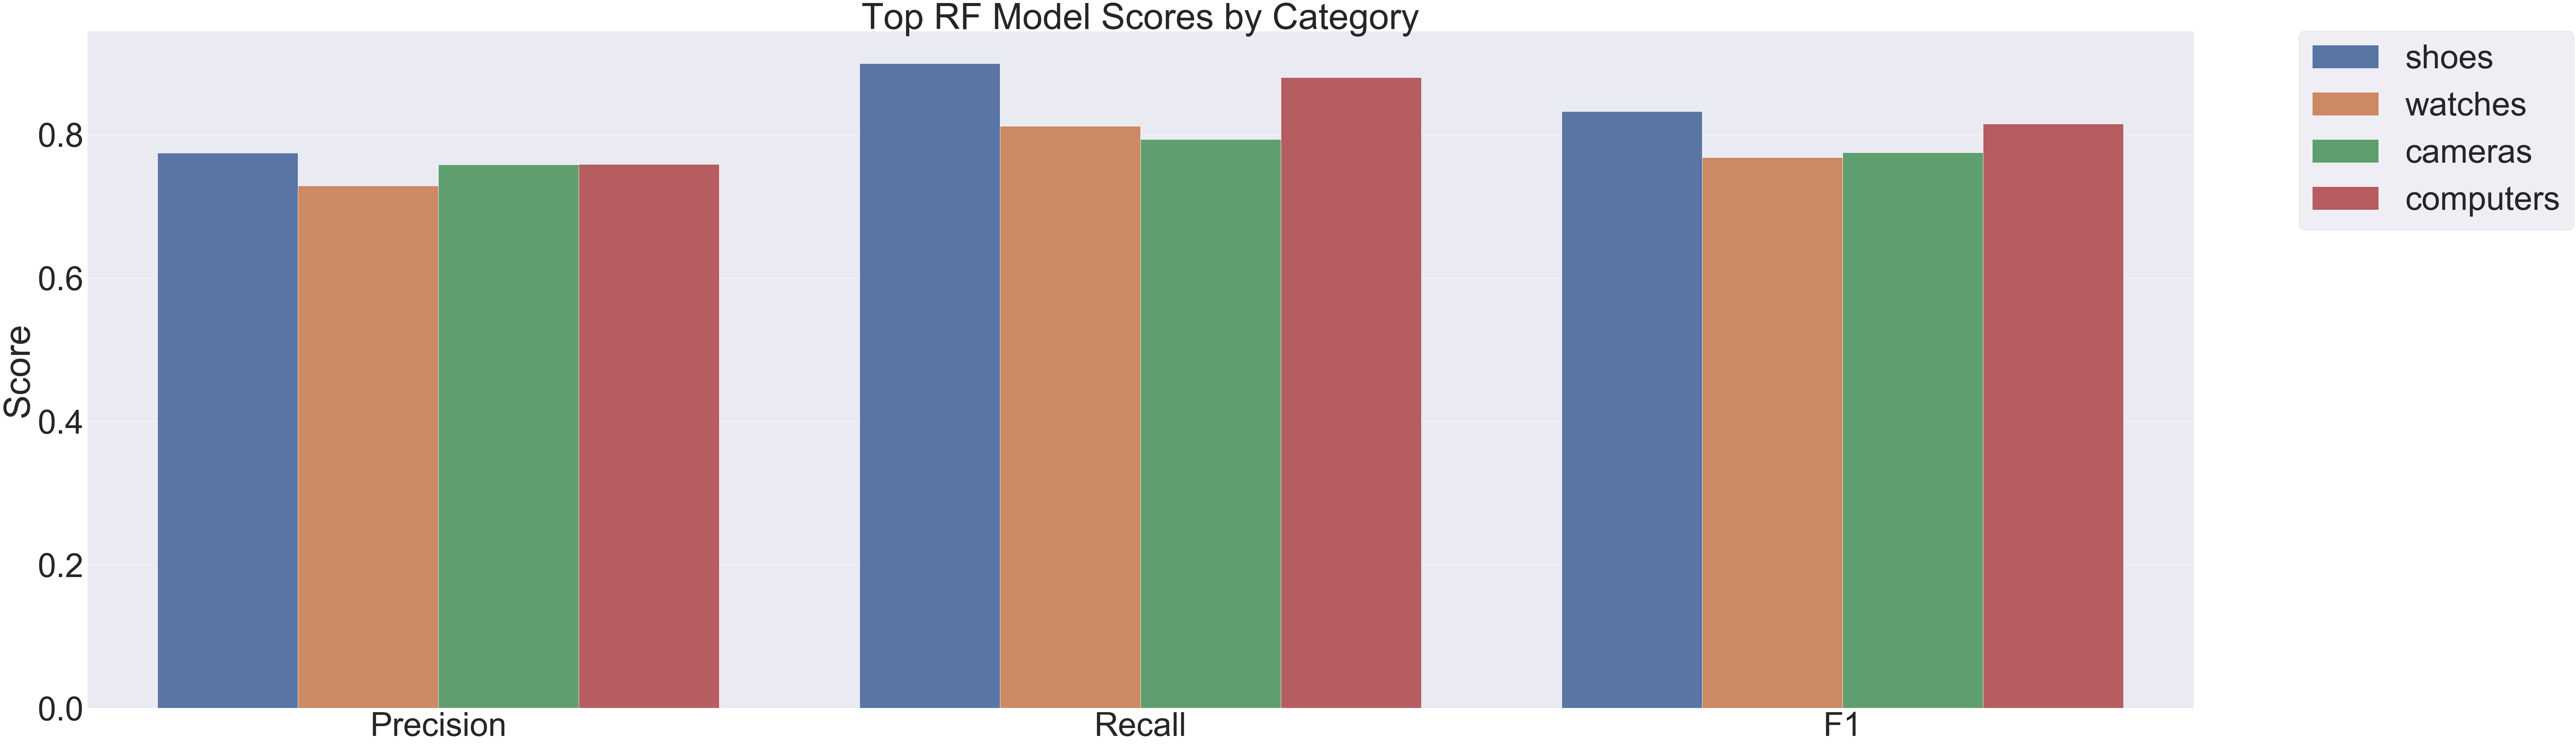

In [42]:
sns.set(font_scale=8)
plt.figure(figsize=(100, 33))

sns.barplot(x='Metric', 
            y='Score',
            hue='Category', 
            data=cat_score_df_melted).set_title('Top RF Model Scores by Category')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
b = plt.xlabel('')

In [59]:
train_cat_counts = train_categories.rename({'file_category': 'Category'}).value_counts()

score_count_df = pd.concat([cat_score_df.set_index('Category').F1, 
                            train_cat_counts], axis=1).rename({'file_category': '# Training Samples'}, axis=1)


C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  after removing the cwd from sys.path.


In [82]:

columns=['NB', 'SVM', 'RF', 'SGB']
acf7_df = pd.DataFrame(acf7_predictions)
# acf9_predictions
# sd9_predictions
# sd100_predictions
# acf7_df
# acf9_predictions
# acf9_predictions
# acf7_predictions
# sd100_predictions
# acf7_models
sd100_models

[GaussianNB(priors=None, var_smoothing=1e-09),
 GaussianNB(priors=None, var_smoothing=1e-09),
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=None, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_jobs=None, oob_score=False,
             random_state=5, verbose=2, warm_start=False),
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.025, loss='deviance', max_depth=None,
               max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=150,
               n_iter_no_change=30, presort='auto', random_state=5,
               subsample

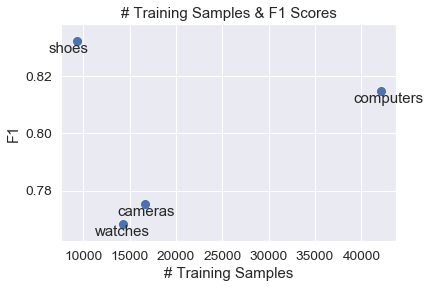

In [47]:
sns.set(font_scale=1.25)

ax = sns.scatterplot(x='# Training Samples',
                y='F1',
                data=score_count_df,
               s=100).set_title('# Training Samples & F1 Scores')

def label_point(x, y, val, ax):
    # source: https://stackoverflow.com/a/46028674/4463701
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] - 3000, point['y'] - .004, str(point['val']))

label_point(score_count_df['# Training Samples'], score_count_df.F1, score_count_df.index.to_series(), plt.gca())  

In [49]:
test_feature_pairs_features_only = attribute_comp_features_9[train_test_feature_pairs.dataset=='test'][ALL_FEATURES]
null_counts = test_feature_pairs_features_only.apply(lambda x: np.sum(x == 0), axis=1)
correctly_pred = test_labels == acf9_rf_pred

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


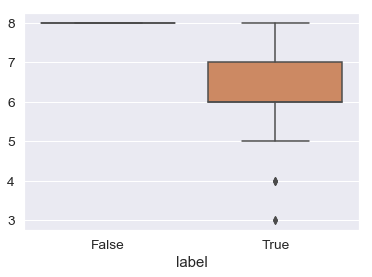

In [50]:
sns.boxplot(x=correctly_pred, y=null_counts)



,Null Counts
Category,
cameras,6.0
computers,6.0
shoes,7.0
watches,6.0


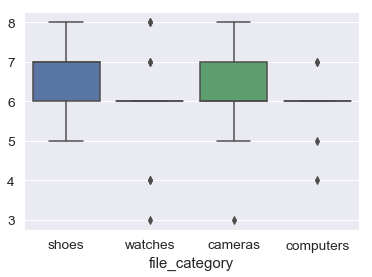

In [51]:
sns.boxplot(x=test_categories, y=null_counts)

pd.DataFrame({'Category': test_categories, 'Null Counts': null_counts}).groupby('Category').median()

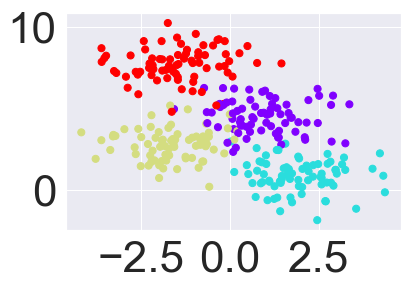

In [83]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

In [84]:
X

array([[ 2.45830537e-02,  2.96215652e+00],
       [-1.52392631e+00,  7.12573205e+00],
       [ 1.27450825e+00,  5.63017322e+00],
       [-8.65523345e-01,  7.80121774e+00],
       [ 7.48740670e-01,  2.55579434e+00],
       [ 4.35918422e+00, -1.62352163e-01],
       [-1.99576820e+00,  7.16440976e-01],
       [ 1.70536064e+00,  4.43277024e+00],
       [ 4.90616903e-01,  8.82985441e+00],
       [-3.52995502e-01,  9.21042408e+00],
       [-1.83601846e+00,  2.68441560e+00],
       [-3.61784268e+00,  8.69951232e+00],
       [ 1.42013331e+00,  4.63746165e+00],
       [-2.88089030e+00,  6.26769229e+00],
       [ 1.05505217e+00, -6.47107437e-01],
       [ 1.05472929e-01,  3.72493766e+00],
       [ 1.13121750e+00,  4.68194985e+00],
       [ 2.91209813e+00,  2.46638067e-01],
       [-7.60240832e-01,  3.27417508e+00],
       [-7.79715679e-01,  1.72893731e+00],
       [ 3.15492712e+00,  1.55292739e+00],
       [ 1.59167155e+00,  1.37914513e+00],
       [ 5.73093132e-01,  5.52623240e+00],
       [-2.